# Градиентный спуск

Мы помним, что в случае многомерной линейной регрессии (когда количество фичей $m$) аналитическое решение имеет вид
$$
\overline{w} = \left(X^TX\right)^{-1}X^T\overline{y}
$$

Где $X$ - т.н. матрица объекты-признаки размерности *количество объектов* x *количество признаков*.

У аналитического решения есть ряд недостатков
* Вычислительная сложность из-за матричного перемножения $O(n^3)$, где $n$ - размерность матрицы. При увеличении размерности матрицы в 10 раз сложность вычислений увеличивается в $10^3=1000$ раз
* Неустойчивость вычислений - пытаемся найти обратную матрицу, которая может не существовать, в этом случае в алгоритме нахождения обратной матрицы возникает деление на ноль

С неустойчивостью вычислений, например, связано предупреждение **LinAlgWarning:**:
$$
X^TX = 
\left[
\begin{array}{cc}
2 & 1 \\
4 & 2 
\end{array}
\right]
$$

Допустим, хотим вычислить коэффициенты аналитически. Если попытаемся найти обратную матрицу $(X^TX)^{-1}$, мы получим сообщение об ошибке:

In [1]:
import numpy as np
# матрица из примера
X = np.array([[2,1],[4,2]])
# пытаемся найти обратную
np.linalg.inv(X)

LinAlgError: Singular matrix

Значит, мы не всегда можем применять аналитическую формулу $\overline{w} = \left(X^TX\right)^{-1}X^T\overline{y}$ для нахождения коэффициентов $\overline{w}$ Как же быть, если задачу решать все равно надо?

Решение этих проблем нашли математики - давайте вычислять коэффициенты линейной регрессии не аналитически, а с помощью приближённых численных методов. Тогда не надо будет перемножать матрицы или находить обратные матрицы. Самый простой и эффективный из этих методов называется методом *градиентного спуска*. Суть метода состоит в обновлении параметров модели $w$ по маленьким шажкам (вместо того, чтобы находить их сразу) - это и есть градиентный спуск.

Каждый такой шажок назвается "итерация".

Мы знаем, что коэффициенты обучаются при помощи минимизации функции ошибок:

$$
L(y,w) = \sum_{i=1}^{N}\left(y_i - \hat{y_i}\right)^2
$$

Эта функция квадратичная - следовательно, имеет форму параболы. Минимум параболы соответствует минимуму ошибки - давайте как-то понемногу "подкручивать" параметры, чтобы по шажкам спуститься в точку, где ошибка будет минимальной - в этой точке и находятся параметры $w$, которые мы ищем. Правила обновления весов должны быть очень простыми и не содержать матричных перемножений

![grad_descent_single_measure](https://248006.selcdn.ru/public/Data-science-3/img/grad_descent_single_measure.png)

## Математика

"Маленькие шажки", которыми мы двигаемся к оптимальному решению в виде формулы, выглядят следующим образом:
$$
w^{k+1} = w^k - \eta\nabla L(w)
$$
Переменная $\eta$ в формуле - т.н. *шаг градиентного спуска*.

Где $\nabla L(w)$ - вектор градиента функции. Этот вектор обладает следующими свойствами: 

* имеет размерность вектора параметров. Если два параметра $[w_1,w_0]$ - в векторе будет два элемента
* элемент градиента под номером $i$ - это частная производная (вспоминаем математику за 11 класс и [смотрим в Википедию](https://ru.wikipedia.org/wiki/Производная_функции ) ) функции потерь $L(y, w)$ по параметру $w_i$

Вектор антиградиента всегда направлен в сторону уменьшения функции - в этом и есть всё волшебство! Мы будем двигаться в сторону минимума функции ошибки, потому что знаем как туда попасть - надо следовать по антиградиенту.

На картинке одномерный случай. Синяя стрелка - градиент, красная - антиградиент. Видно, что если двигаться по вектору антиградиента, то свалимся в минимум функции за конечное число шагов
![grad_vector](https://248006.selcdn.ru/public/Data-science-3/img/grad_vector.png)

Алгоритм визуально выглядит довольно интуитивно - (1) у тебя есть вектор-стрелочка (2) шагай по стрелочке, пока не попадёшь на дно "оврага", который представляет собой целевую функцию . В трёхмерном случае оптимальное значение функции находится в центре концентрицеских эллипсов (эллипс - проекция трёхмерной фигуры функции потерь на плоскость):

![grad_descent](https://248006.selcdn.ru/public/Data-science-3/img/grad_descent_intuit.png)

Как туда добраться, двигаясь маленькими шажками?

1. Стартуем алгоритм в случайной начальной точке $x^0$  
1. Вычисляем направление антиградиента $-f'(x^0)$
1. Перемещаемся по направлению градиента в точку $x^1 = x^0 - \eta f'(x^0)$
1. Повторяем шаги (1-3) для попадания в точку $x^2$
1. $\ldots$
1. Profit! Достигли оптимальной точки $x^*$

Алгоритм выше - универсальный, он позволяет найти точку минимума любой функции $f(x)$. А как же нам найти минимум функции качества линейной регрессии $L$?

Чтобы реализовать алгоритм градиентного спуска, выпишем частные прозводные функции качества линейной регрессии $L$ для параметров $\overline{w} = [w_1,\ldots,w_m]$ в простейшем случае $n=1$, то есть для одного обучающего примера (одного наблюдения):
$$
\left\{
\begin{array}{cc}
\frac{\partial L}{\partial w_0} = 2\cdot(-1)\cdot1\cdot (y_1 - (w_0x_0^1 + \ldots+w_mx_m^1)) &\\
\frac{\partial L}{\partial w_k} = 2\cdot(-1)\cdot x_1^1 \cdot (y_1 - (w_0x_0^1 + \ldots+w_mx_m^1)) &  k\neq 0\\
\end{array}
\right.
$$

В формуле все обозначения вам известны

* $w_0, \ldots, w_m$ - коэффициенты линейной регрессиии $m$ - количество фичей
* $x_0, \ldots, x_m$ - фичи.

Эту формулу с частными производными можно легко обобщить на случай, когда в обучающей выборке не один объект, а $n$ - просто добавляем сумму по всем объектам от 1 до $n$:
$$
\left\{
\begin{array}{cc}
\frac{\partial L}{\partial w_0} = \frac{2}{n}\cdot(-1)\cdot \sum_{i=1}^{n} 1\cdot \left(y_i - \sum_{j=1}^{m}w_jx_j^i\right) &\\
\frac{\partial L}{\partial w_k} = \frac{2}{n}\cdot(-1)\cdot \sum_{i=1}^{n} x_k^i \cdot\left(y_i - \sum_{j=1}^{m}w_jx_j^i\right) & k\neq 0 \\
\end{array}
\right.
$$

Что значат переменные в этой формуле?
* $n$ - число точек в обучающей выборке
* $m$ - число фичей в датасете
* $k$ - номер коэффициента в списке параметров линейной регрессии $w = [w_0,\ldots,w_m]$
* $y_i$ - значение целевой переменной на объекте обучающей выборки под номером $i$
* $x_j^i$ - значение фичи под номером $j$ на объекте обучающей выборки под номером $i$


**ВНИМАНИЕ** я выписал эти формулы в тетрадке, потому что знаю, как искать производную. Это знание выходит за пределы курса. Слушателю не нужно знать, как они получаются, но если очень хочется - можно посмотреть видео на ютубе: https://www.youtube.com/watch?v=sDv4f4s2SB8

Алгоритм градиентного спуска следующий:

1. Вычислить градиент $\nabla L(w)$
1. Вычислить новый вектор  $w^{k+1} = w^k - \eta\nabla L(w)$
1. Повторять пункты до тех пор, пока $w^{k+1}$ и $w^{k}$ не сойдутся вместе, то есть вектор весов перестанет обновляться

Чтобы лучше понять этот метод, давайте реализуем его "с нуля" на языке Python

In [6]:
import numpy as np
import pandas as pd

data = pd.read_csv('non_linear.csv', sep=',')
data = data[(data.x_train > 1) & (data.x_train < 5)].copy()
data.head()

,x_train,y_train
5,1.182421,1.860341
6,1.251605,1.878928
7,1.270474,2.430015
8,1.402553,2.327856
9,1.427711,2.203649


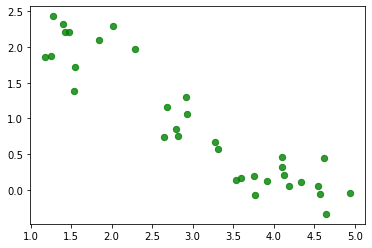

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# основной график
plt.scatter(data.x_train, data.y_train, 40, 'g', 'o', alpha=0.8, label='data')
plt.show()

In [8]:
from scipy.spatial import distance
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def gradient(X, y, w) -> np.array:
    # количество обучающих примеров в выборке
    n = X.shape[0]
    # считаем прогноз
    y_hat = X.dot(w.T)
    # вычисляем ошибку прогноза
    error = y - y_hat
    # дальше pointwise перемножение - умножаем каждую из координат на ошибку
    grad = np.multiply(X, error).sum(axis=0)*(-1.0)*2.0 / n
    return grad, error

In [9]:
def eval_w_next(X, y, eta, w_current):
    # вычисляем градиент
    grad, error = gradient(X, y, w_current)
    # делаем шаг градиентного спуска
    w_next = w_current - eta*grad
    # проверяем условие сходимости
    weight_evolution = distance.euclidean(w_current, w_next)
    return (w_next, weight_evolution, grad)

In [10]:
def gradient_descent(X: np.array, y: np.array, eta=0.01, epsilon=0.001) -> np.array:
    m = X.shape[1] # количество фичей
    # инициализируем рандомом веса
    w = np.random.random(m).reshape(1, -1)
    w_next, weight_evolution, grad = eval_w_next(X, y, eta, w)
    step = 0
    # повторяем до сходимости вектора весов
    while weight_evolution > epsilon:
        w = w_next
        w_next, weight_evolution, grad = eval_w_next(X, y, eta, w)
        step += 1
        if step % 100 ==0:
            print("step %s |w-w_next|=%.5f, grad=%s" % (step, weight_evolution, grad))
    return w

In [11]:
# трансформируем плоский массив X в вектор-столбец
X = data['x_train'].values.reshape(-1, 1)
n = X.shape[0]
# добавляем тривиальный признак w_0, столбец из единиц. См. прошлый урок, почему так
X = np.hstack([
    np.ones(n).reshape(-1,1),
    X
])
w = gradient_descent(X, data['y_train'].values.reshape(-1, 1), eta=0.008)

step 100 |w-w_next|=0.00483, grad=[-0.57992833  0.16752976]
step 200 |w-w_next|=0.00397, grad=[-0.47723799  0.13786456]
step 300 |w-w_next|=0.00327, grad=[-0.39273146  0.11345231]
step 400 |w-w_next|=0.00269, grad=[-0.32318885  0.09336283]
step 500 |w-w_next|=0.00221, grad=[-0.26596044  0.07683068]
step 600 |w-w_next|=0.00182, grad=[-0.21886571  0.06322595]
step 700 |w-w_next|=0.00150, grad=[-0.18011024  0.05203027]
step 800 |w-w_next|=0.00123, grad=[-0.14821737  0.04281705]
step 900 |w-w_next|=0.00102, grad=[-0.1219719   0.03523525]


У нас произошло несколько сотен итераций, на каждой итерации мы:
* вычисляем вектор весов
* смотрим расстояние между новым вектором весов и векторов весов с предыдущего шага
* если изменения в векторе весов небольшие (скажем, четвёртый знак поcле запятой) - останавливаем итерации

Когда вектор перестаёт меняться - говорят, что алгоритм "сошёлся" (имеется в виду сходимость к оптимальной точке) - это значит, что итерации можно останавливать.

In [12]:
support = np.linspace(X.min(), X.max(), num=100)
# делаем предикт - считаем предсказания модели в каждой точке обучающей выборки в виде y=X*w
y_hat = np.hstack([
    np.ones(support.size).reshape(-1, 1),
    support.reshape(-1, 1)
]).dot(w.T)

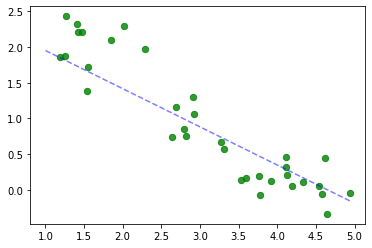

In [13]:
# строим график
plt.plot(support, y_hat, 'b--', alpha=0.5, label='manifold')
plt.scatter(data['x_train'], data['y_train'], 40, 'g', 'o', alpha=0.8, label='data')
plt.show()

# Подготовка

## Импорт библиотек

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# для регрессии
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from scipy.spatial import distance
%matplotlib inline

## Загрузка данных

In [3]:
data = pd.read_csv('non_linear.csv', sep=',')
data = data[(data.x_train > 1) & (data.x_train < 5)].copy()

# Создание модели

In [4]:
X = data['x_train'].values.reshape(-1, 1) # превращаем X из простого массива в вектор-столбец
y = data['y_train'].values

# разбиваем на трейн и валидацию
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=10)

data.head()

,x_train,y_train
5,1.182421,1.860341
6,1.251605,1.878928
7,1.270474,2.430015
8,1.402553,2.327856
9,1.427711,2.203649


Запустим шажки градиентного спуска (те самые итерации). Для градиентного спуска мы используем готовый класс SGDRegressor: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html . Класс принимает следующие параметры


* learning_rate='constant' используем самую простую модификацию спуска из нескольких возможных (см. документацию)
* eta0 - шаг градиентного спуска, в формуле мы его обозначали буквой $\alpha$
* fit_intercept - чтобы обучить коэффициент при "свободном члене" линейной регрессии (см. "Линейная регрессия. Часть 1")
* random_state - этот параметр встречали ранее в этом модуле, он нужен для воспроизводимости вычислений

Функция `partial_fit()`, которую мы вызываем в коде, делает одну итерацию градиентного спуска.

По оси $oX$ отложим количество итераций, а по оси $oY$ - значение метрики качества *MSE*, которое получили на  валидации

Итарации остановлены на шаге 208


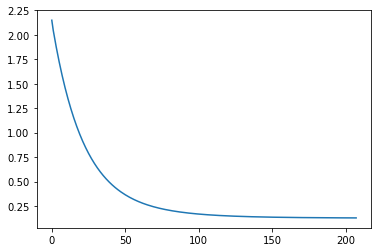

In [5]:
sgd_regressor = SGDRegressor(learning_rate='constant', eta0=0.009, fit_intercept=True, random_state=42)
w_current, epsilon = np.random.random(2), 0.0001
weight_evolution, mse_evolution = [], [] # изменения весов и ошибка на валидации
for step in list(range(800)):
    sgd_regressor = sgd_regressor.partial_fit(X_train, y_train)
    weight_evolution.append(distance.euclidean(w_current, sgd_regressor.coef_))
    if weight_evolution[-1]<epsilon:
        print("Итарации остановлены на шаге %d" % step); break
    mse_evolution.append(mean_squared_error(y_valid, sgd_regressor.predict(X_valid)))
    w_current = sgd_regressor.coef_.copy()
plt.plot(range(step), mse_evolution)